In [397]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


from scipy.stats import entropy

import warnings
warnings.filterwarnings('ignore')

Conclusions:
- na

In [37]:
file = 'anonymized-curriculum-access.txt'
log = pd.read_csv(file,names =['date', 'time','path','id','mystery','ip'], sep = ' ', parse_dates = True)
log['datetime'] = pd.to_datetime(log.date+' '+log.time)
log.set_index('datetime',inplace = True)
log.head()

,date,time,path,id,mystery,ip
datetime,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


identify cohorts

In [38]:
local_log = log[(log.ip == '97.105.19.61')|(log.ip =='97.105.19.58')]

In [430]:
log_start = log.index.min()
people = log.id.unique()
start_end_dates = pd.DataFrame(columns=['id','start_date','end_date', 'range'])
for person in people:
    start_date = (local_log[local_log.id == person].index.min()-log_start).days
    end_date = (local_log[local_log.id == person].index.max()-log_start).days
    date_range = end_date-start_date
    start_end_dates = start_end_dates.append({'id': person, 'start_date': start_date, 'end_date':end_date, 'range':date_range}, ignore_index = True)
start_end_dates.set_index('id', inplace = True)
start_end_dates.head()

,start_date,end_date,range
id,,,
1.0,0,661,661
2.0,0,104,104
3.0,0,108,108
4.0,0,60,60
5.0,0,98,98


In [439]:
current_staff_student = start_end_dates.dropna()

In [440]:
scaled_currents = current_staff_student.copy()
scaled_currents['start_date'] = MinMaxScaler().fit_transform(current_staff_student[['start_date']])
scaled_currents

,start_date,end_date,range,program
id,,,,
1.0,0.000000,661,661,0
2.0,0.000000,104,104,0
3.0,0.000000,108,108,0
4.0,0.000000,60,60,0
5.0,0.000000,98,98,0
6.0,0.000000,111,111,0
7.0,0.000000,108,108,0
8.0,0.000000,47,47,0
9.0,0.000000,105,105,0


In [477]:
dbscan = DBSCAN(eps = .001, min_samples=3, metric = 'euclidean')
group = dbscan.fit_predict(scaled_currents[['start_date', 'program']])
current_staff_student['group'] = group#.astype(str)

In [478]:
current_staff_student.group.value_counts()

-1     72
 0     46
 5     26
 16    24
 9     24
 14    24
 10    23
 17    23
 6     22
 12    21
 3     21
 8     21
 15    20
 13    19
 11    16
 1      6
 4      4
 2      4
 7      3
Name: group, dtype: int64

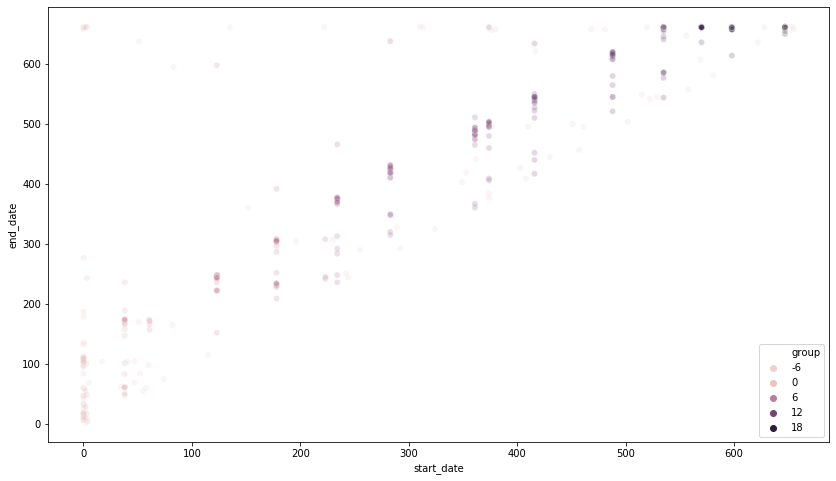

In [481]:
plt.figure(figsize=(14,8))
sns.scatterplot(data = current_staff_student[['start_date','end_date']], x = 'start_date', y = 'end_date', hue = current_staff_student.group, alpha = .2)#, palette=['grey']+['red','blue']*7+['red'], alpha = .3)


In [188]:
local_log.mystery.value_counts()

24.0    26475
33.0    25872
29.0    24141
32.0    20763
23.0    20709
22.0    20200
26.0    20094
28.0    17861
25.0    17394
31.0    17390
27.0    15868
34.0    12070
51.0     9415
1.0      7573
14.0     6525
21.0     2814
52.0     2169
17.0     2097
8.0      1354
16.0      423
18.0      362
7.0        86
15.0       78
19.0       55
13.0       31
Name: mystery, dtype: int64

In [221]:
log.mystery.value_counts()

29.0    35969
24.0    35039
33.0    34433
22.0    28875
23.0    28056
32.0    26801
26.0    26760
25.0    25233
31.0    22665
28.0    20677
27.0    20198
34.0    15519
51.0    10835
14.0     9069
1.0      8877
21.0     7181
17.0     3792
52.0     2896
13.0     2610
8.0      1671
18.0     1603
19.0     1142
16.0      740
15.0      691
7.0       461
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: mystery, dtype: int64

Find most common words among groups

In [256]:
log.mystery.value_counts()

29.0    35969
24.0    35039
33.0    34433
22.0    28875
23.0    28056
32.0    26801
26.0    26760
25.0    25233
31.0    22665
28.0    20677
27.0    20198
34.0    15519
51.0    10835
14.0     9069
1.0      8877
21.0     7181
17.0     3792
52.0     2896
13.0     2610
8.0      1671
18.0     1603
19.0     1142
16.0      740
15.0      691
7.0       461
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: mystery, dtype: int64

In [277]:
web_dev_words = log[log.mystery == 29].path.str.split('/').sum()

In [295]:
web_dev_words= [x for x in web_dev_words if x != '']
pd.Series(web_dev_words).value_counts()

javascript-i                     5543
mysql                            4613
html-css                         3738
jquery                           3331
spring                           3048
java-iii                         2778
java-ii                          2713
javascript-ii                    2471
java-i                           2195
fundamentals                     2019
introduction                     1922
toc                              1294
css-ii                           1185
css-i                            1112
appendix                         1099
bom-and-dom                       969
relationships                     911
arrays                            811
events                            721
examples                          683
search                            673
search_index.json                 673
ajax                              615
clauses                           523
functions                         516
essential-methods                 500
objects     

In [370]:
web_dev_words = log[log.mystery == 29].path.apply(lambda x: re.split('\W|\_|\d', x)).sum()

In [371]:
dat_sci_words = log[log.mystery == 34].path.apply(lambda x: re.split('\W|\_|\d', x)).sum()

In [331]:
# for i in web_dev_words:
#     if i in dat_sci_words:
#         web_dev_words= [x for x in web_dev_words if x !=i]
#         dat_sci_words= [x for x in dat_sci_words if x !=i]


In [372]:
web_dev_words= [x for x in web_dev_words if x not in ['','i','ii','iii','and','fundamentals']]
key_wd_words = pd.Series(web_dev_words).value_counts().head(10).index
key_wd_words

Index(['javascript', 'java', 'css', 'mysql', 'html', 'jquery', 'spring',
       'introduction', 'dom', 'events'],
      dtype='object')

In [373]:
dat_sci_words= [x for x in dat_sci_words if x not in  ['','i','ii','iii','to','or','and','jpg','appendix','fundamentals']]
key_ds_words = pd.Series(dat_sci_words).value_counts().head(10).index
key_ds_words

Index(['python', 'regression', 'sql', 'overview', 'stats', 'classification',
       'data', 'clustering', 'intro', 'cli'],
      dtype='object')

In [374]:
log['key_words'] = log.path.apply(lambda x: re.split('\W|\_|\d', x))

In [375]:
person_searches = log.groupby('id').key_words.sum()
person_searches.head()

id
1    [, , java, ii, java, ii, object, oriented, pro...
2    [javascript, i, conditionals, javascript, i, l...
3    [javascript, i, conditionals, javascript, i, f...
4    [javascript, i, functions, javascript, i, intr...
5    [mkdocs, search, index, json, appendix, furthe...
Name: key_words, dtype: object

In [376]:
def program_rating(x):
    key_ds_words = ['python', 'classification', 'clustering', 'storytelling', 'explore',
       'timeseries', 'science', 'prep', 'dataframes', 'more']
    key_wd_words = ['jquery', 'spring', 'dom', 'events', 'bom', 'appendix', 'ajax',
       'arrays', 'methods', 'bootstrap']
    ds_count = 0
    all_key_wds = 0
    for i in x:
        if i in (key_ds_words + key_wd_words):
            all_key_wds += 1
            if i in key_ds_words:
                ds_count += 1
    if all_key_wds == 0:
        return [np.nan,np.nan]
    ds_score = (ds_count/all_key_wds)
    return [ds_score, 1-ds_score]

In [377]:
person_ratings = person_searches.apply(program_rating).apply(pd.Series)
person_ratings.rename(columns = {0:'ds_score',1:'wd_score'}, inplace = True)
person_ratings

,ds_score,wd_score
id,,
1,0.429003,0.570997
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
5,0.000000,1.000000
6,0.000000,1.000000
7,0.000000,1.000000
8,0.000000,1.000000
9,0.000000,1.000000


In [452]:
person_ratings[(person_ratings.ds_score > .25)&(person_ratings.ds_score < .75)]

,ds_score,wd_score
id,,
1,0.429003,0.570997
11,0.369852,0.630148
68,0.281250,0.718750
70,0.428571,0.571429
88,0.483871,0.516129
94,0.400000,0.600000
139,0.333333,0.666667
146,0.350000,0.650000
156,0.428571,0.571429


In [453]:
ds_ids = person_ratings[person_ratings.ds_score > .5].index.tolist()
log[log.id.apply(lambda x: x in ds_ids)].mystery.value_counts()

34.0    15502
28.0     3407
19.0       96
1.0        48
7.0        35
Name: mystery, dtype: int64

In [454]:
start_end_dates.drop(columns='program', inplace=True)

In [455]:
program = person_ratings.ds_score.apply(lambda x: 1 if x > .5 else 0)
start_end_dates = start_end_dates.join(program, on = 'id').rename(columns = {'ds_score':'program'}).dropna()
start_end_dates.head()

,start_date,end_date,range,program
id,,,,
1.0,0,661,661,0
2.0,0,104,104,0
3.0,0,108,108,0
4.0,0,60,60,0
5.0,0,98,98,0


In [456]:
start_end_dates[start_end_dates.program == 1]

,start_date,end_date,range,program
id,,,,
248.0,222,661,439,1
349.0,374,500,126,1
351.0,374,500,126,1
352.0,374,496,122,1
353.0,374,504,130,1
354.0,374,503,129,1
355.0,374,495,121,1
357.0,374,495,121,1
358.0,374,661,287,1
